In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
import numpy as np
import torch
from geometry import *
from utils import Plot_Grid
from solver import *
from models import *
#from models import _init_weights
from mesh import *
from boundary import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def _init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, 1. / np.sqrt(y))
        m.bias.data.fill_(0)

In [3]:
def radial_bipolar(r_out, r_inn, ecc):
    r = r_inn/r_out
    xi_out = np.arccosh( (r*(1+ecc**2) + (1-ecc**2)) / (2*r*ecc) )
    xi_inn = np.arccosh( (r*(1-ecc**2) + (1+ecc**2)) / (2*ecc) )
    c_1 = r_inn*np.sinh(xi_out)
    c_2 = r_out*np.sinh(xi_inn)
    np.testing.assert_allclose(c_1, c_2, rtol=1e-10, atol=0)
    return xi_out, xi_inn, c_1

In [4]:
r_out = 1.0
r_inn = 0.5
ecc = 0.5
xi_out, xi_inn, c = radial_bipolar(r_out,r_inn, ecc)
print(f'Outer Xi: {xi_out} Inner Xi: {xi_inn} Focal Point: {c}')

Outer Xi: 1.6699190305877698 Inner Xi: 1.0667324319014355 Focal Point: 1.2808688457449495


In [5]:
n = 0.4
tau = 0.
dpdz = 10

In [6]:
class Gov_Eq(PDE):
    
    def PDELoss(self, inputs, outputs):
        
        # seperate the inputs
        xi, eta = inputs[:,0], inputs[:,1]
        
        # compute the velocity gradients
        U_grad = self.compute_grad(outputs, inputs)
        du_dxi, du_deta = U_grad[:,0], U_grad[:,1]
        
        # geometric constrains
        a, PSI = self.Geometric_data(xi_inn, xi, eta)
        
        # compute the apparent viscosity
        vis = self.HB_model(du_dxi, du_deta, PSI, a, tau, n)
        
        # compute the left side of governing equation
        left = vis*du_dxi
        
        # compute right side of governing equation
        right = vis*du_deta
        
        # differentiate left side
        d2u_dxi2 = self.compute_grad(left, inputs)[:,0]
        
        # differentiate right side
        d2u_deta2 = self.compute_grad(right, inputs)[:,1]
        
        # combine left and right with non-dimenaiosnal pressure loss
        gov_eq = d2u_dxi2 + d2u_deta2 + dpdz*( a/PSI )**2
        
        return {'PDE': gov_eq}
        
    def HB_model(self, du_dxi, du_deta, PSI, a, tau, n):
        # calculate shear rate
        shear = self.shear_rate(du_dxi, du_deta, PSI)
        
        # calculate the apparent viscosity
        app_vis = (tau/shear)*a + (torch.abs_(shear/a))**(n-1)
        
        return app_vis
    
#     def shear_rate(self, du_dxi, du_deta, PSI, tol = 1e-2):
#         tol = torch.Tensor([tol]).float()
#         shear_ =  torch.sqrt(du_dxi**2 + du_deta**2)
#         shear = torch.where(shear_>= torch.tensor([0.0]).float(), shear_, tol)
#         shear = PSI * shear
#         return torch.abs_(shear)

# define the modified shear rate
    def shear_rate(self, du_dxi, du_deta, PSI, tol = 1e-5):
        
        # calculate the shear rate
        shear_ = torch.sqrt(du_dxi**2 + du_deta**2)
        
        # create mask
        dummy_shear = torch.zeros_like(shear_)
        mask = shear_ <= tol
        indices = torch.nonzero(mask).unsqueeze(1)
        dummy_shear[indices] = tol**2
        shear = torch.sqrt((du_dxi+dummy_shear)**2 + (du_deta+dummy_shear)**2)
        shear = PSI *shear
        #shear = (1/jac)*((dydeta*(dudxi+dummy_shear) - dydxi*(dudeta+dummy_shear))**2 + (dxdxi*(dudeta+dummy_shear) - dxdeta*(dudxi+dummy_shear))**2)**(0.5)
        
        return torch.abs_(shear)
    
    def Geometric_data(self, xi_inn, xi, eta):
        xi_in = torch.Tensor([xi_inn]).float()
        # PSI = cosh(xi) - cos(eta)
        PSI = torch.cosh(xi) - torch.cos(eta)
        # a = sinh(xi_inn)
        a = torch.sinh(xi_in)
        
        return a, PSI
        
# Initialize the PDE equation
pde = Gov_Eq(inputs =('xi', 'eta'), outputs = 'u')

pass


In [7]:
# define the mesh
nx = 60
ny = 80
xi = np.linspace(xi_inn, xi_out, nx)
eta = np.linspace(0, np.pi, ny)
mesh = Mesh({'xi':xi, 'eta':eta})

In [8]:
pde.set_mesh(mesh)

In [9]:
# # define the Dirichlet boundary conditions
# #u = 0 @ xi = xi_inn & xi_out
# xi_ = np.array([xi_inn, xi_out])
# u_ = np.full(2*len(eta), 0)
# inner = Dirichlet({'xi':xi_, 'eta':eta}, {'u':u_}, name='Dirichlet')
# pde.add_boundary(inner)
##################################################################################
class Trial_Solution:
    def __init__(self, model, boundary):
        self.model = model
        self.model.apply(_init_weights)
        self.var = tuple(boundary.keys())
        self.bound = list(boundary.values())
        
    def __call__(self,input_data):
        #x = input_data[:,0].reshape(-1,1)
        trial = (input_data[:,0].reshape(-1,1) - xi_inn)*(xi_out-input_data[:,0].reshape(-1,1))*self.model(input_data)
        return trial

In [10]:
# define the Neumann Boundary Condition
# du_deta = 0 @ eta = 0 & pie
eta_ = np.array([0, np.pi])
class Neumann(Neumann):
    def neumann_loss(self, inputs, outputs):
        du_deta = self.compute_grad(outputs, inputs)[:,1]
        return {'grad_Eta': du_deta}
outer = Neumann({'xi': xi, 'eta':eta_}, name='Neumann')
pde.add_boundary(outer)

In [11]:
btach_size = 1100
lr = 0.001
epochs = 200
hid_dim = 300
layers = 7
in_dim = len(pde.input)
out_dim = len(pde.output)
activation = Sine()
#activation = torch.nn.Tanh()

net = MLP(in_dim, out_dim, layers, hid_dim, act=activation)
trial = Trial_Solution(net, {'xi_inn':xi_inn, 'xi_out':xi_out})


optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, pct_start=0.1, total_steps=epochs)

pde.compile(trial,optimizer, scheduler)

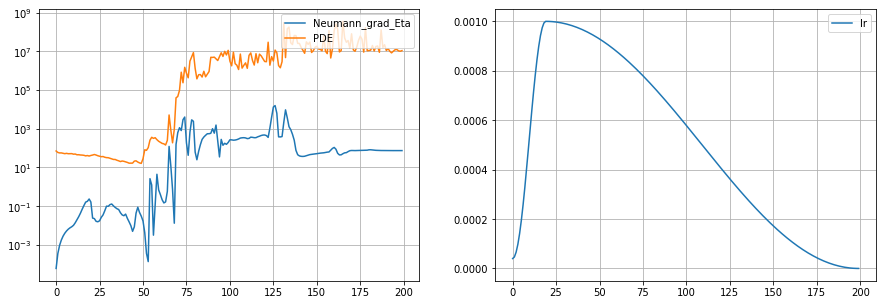

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


Wall time: 7min 8s


In [12]:
%time hist = pde.solve(epochs, btach_size)

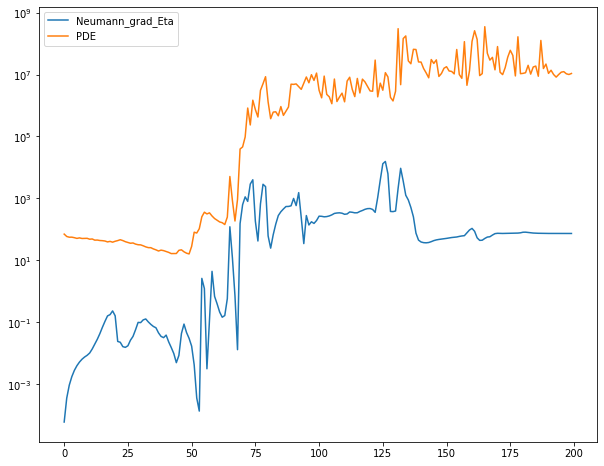

In [13]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

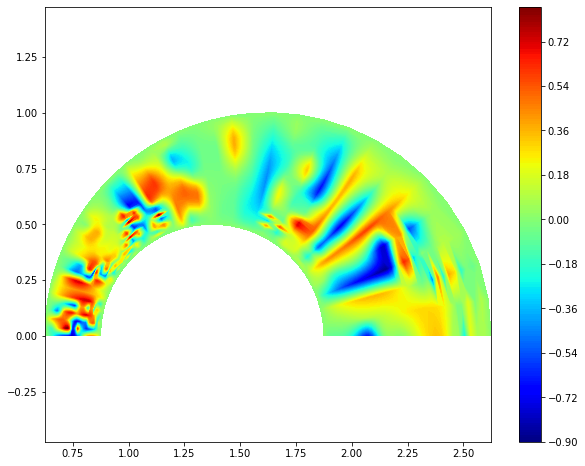

In [14]:
xi = np.linspace(xi_inn, xi_out, 40)
eta = np.linspace(0, np.pi, 40)
eval_mesh = Mesh({'xi':xi, 'eta':eta})
#pred = pde.eval(eval_mesh).view(len(eta),len(xi)).numpy()
pred = trial(eval_mesh.gen_data[:]).view(len(eta),len(xi)).detach().numpy()
def plot_circle(r_out, r_inn, ecc, sample_space=100):
    # find eta1, eta2, anc c
    eta_1, eta_2, c = radial_bipolar(r_out, r_inn, ecc)
    coth_1 = np.cosh(eta_1)/np.sinh(eta_1)
    coth_2 = np.cosh(eta_2)/ np.sinh(eta_1)
    # find center of both circles
    center_1 = c*coth_1
    center_2 = c*coth_2
    
    # radius of both circles
    rad_1 = c/np.sinh(eta_1)
    rad_2 = c/np.sinh(eta_2)
    
    # define the theta
    theta = powspace(0,np.pi, sample_space)
    
    # define x and y coords
    x_1 = c*np.sinh(eta_1)/( np.cosh(eta_1) - np.cos(theta) )
    y_1 = c*np.sin(theta)/( np.cosh(eta_1) - np.cos(theta) )
    
    x_2 = c*np.sinh(eta_2)/( np.cosh(eta_2) - np.cos(theta) )
    y_2 = c*np.sin(theta)/( np.cosh(eta_2) - np.cos(theta) )
    
    plt.plot(x_1, y_1)
    plt.plot(x_2, y_2)
    plt.axis('equal')
    
xi, eta = np.meshgrid(xi,eta)
x = c*np.sinh(xi)/( np.cosh(xi) - np.cos(eta) )
y = c*np.sin(eta)/( np.cosh(xi) - np.cos(eta) )
plt.figure(figsize=(10,8))
plt.contourf(x,y, pred, 200, cmap='jet')
plt.colorbar()
plt.axis('equal');

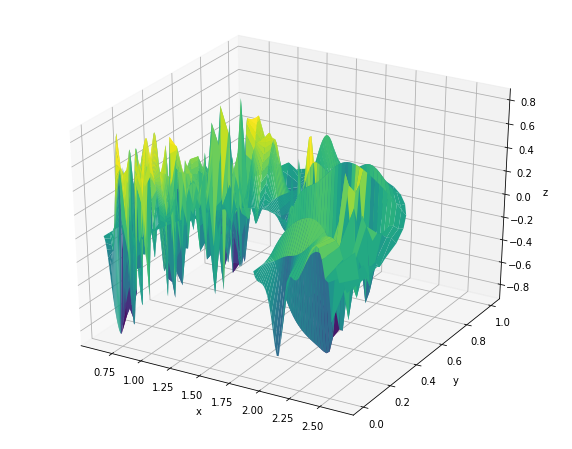

In [15]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, pred,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');


In [16]:
pde.compute_grad(trial(eval_mesh.gen_data[:]), eval_mesh.gen_data[:])

RuntimeError: One of the differentiated Tensors does not require grad

In [ ]:
#eval_mesh.gen_data[:].requires_grad =True
test = pde.compute_grad(trial(data), (data))
u_x, u_y = test[:,0], test[:,1]

In [ ]:
data = eval_mesh.gen_data[:]
data.requires_grad = True
data.requires_grad

In [ ]:
xi, eta = np.meshgrid(xi,eta)
x = c*np.sinh(xi)/( np.cosh(xi) - np.cos(eta) )
y = c*np.sin(eta)/( np.cosh(xi) - np.cos(eta) )
plt.figure(figsize=(10,8))
plt.contourf(x,y, u_x.detach().numpy().reshape(80,60), 100, cmap='jet')
plt.colorbar()
plt.axis('equal');